In this notebook we will look at various fields in ERA

In [1]:
import glob
import cdsapi
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from cdo import *
import numpy as np
import cartopy.crs as ccrs
from metpy.plots import SkewT
from metpy.units import units
from metpy.calc import dewpoint_from_specific_humidity
import xarray as xr 
import pandas as pd


file='/Users/tompkins/TEACHING/DATA/ERA5.nc'
anfile='/Users/tompkins/TEACHING/DATA/ERA5_year.nc'

Now we will download a number of fields...  We could also loop overfields, but it is much more efficient to combine them into a single retrieve request. 

In [2]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'format': 'netcdf',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': [
            '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
            'high_cloud_cover', 'low_cloud_cover', 'medium_cloud_cover',
            'sea_surface_temperature', 'surface_latent_heat_flux', 'surface_sensible_heat_flux',
            'toa_incident_solar_radiation', 'top_net_solar_radiation', 'top_net_solar_radiation_clear_sky',
            'top_net_thermal_radiation', 'top_net_thermal_radiation_clear_sky', 'total_cloud_cover',
            'total_precipitation',
        ],
        'year': '2020',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
    },
    file)

2022-01-07 11:50:04,952 INFO Welcome to the CDS


2022-01-07 11:50:04,954 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means


2022-01-07 11:50:05,027 INFO Request is queued


KeyboardInterrupt: 

let's open up the file and take a look at the output...  all the variables we requested are in the file and in this way we can see the short names they have that we will need to refer to them.  This opertion is essentially the same as using ncdump.

In [47]:
ds=Dataset(file)
ds.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (1440,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (721,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (12,)
 filling on, default _FillValue of -2147483647 used,
 'u10': <class 'netCDF4._netCDF4.Variable'>
 int16 u10(time, latitude, longitude)
     scale_factor: 0.00043575012752811263
     add_offset: -1.256208857119428
     _FillValue: -32767
     missing_value: -32767
     units: m s**-1
     long_name: 10 metre U wind 

The file has data for one year, thus 12 timesteps.  Let's take the year average.  Now we could do this with xarray for example, or indeed numpy functions, but let's see how we can use cdo from within python

In [48]:
# set cdo to an incidence of Cdo(), you don't need to do this, but cdo.func is neater than Cdo().func
#cdo = Cdo()
anfile='/Users/tompkins/TEACHING/DATA/ERA5_year.nc'
#cdo.yearmean(input=cdo.yearmean(input=file,output=anfile,options="-O "))

ds=Dataset(anfile)
lons=ds.variables["longitude"][:]
lats=ds.variables["latitude"][:]
import cartopy

We now define a map plot routine in order to show the 

In [49]:
def make_plot(lons,lats,data,title=""):
      
    ax1=plt.axes(projection=ccrs.Orthographic(),transform=ccrs.PlateCarree())
    cf=plt.pcolormesh(lons, lats, sst,transform=ccrs.Orthographic(),)
    #plt.contour(lons,lats,sst, 8, colors='k')
    ax1.coastlines()
    ax1.set_title(title)
    plt.colorbar(cf, ax=ax1,orientation='horizontal')
    gl=ax1.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    plt.show()


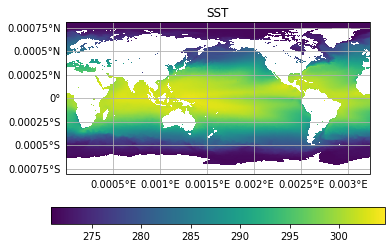

In [50]:

sst=ds.variables["sst"][0,:,:]
make_plot(lons,lats,sst,title="SST")

In [ ]:
file_plevs='/Users/tompkins/TEACHING/DATA/tq_plevs.nc'
plevs=[ '1', '2', '3',
            '5', '7', '10',
            '20', '30', '50',
            '70', '100', '125',
            '150', '175', '200',
            '225', '250', '300',
            '350', '400', '450',
            '500', '550', '600',
            '650', '700', '750',
            '775', '800', '825',
            '850', '875', '900',
            '925', '950', '975',
            '1000']
plevs = units.Quantity(plevs,"hPa")

In [ ]:
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-pressure-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': [
            'specific_humidity', 'temperature',
        ],
        'pressure_level': plevs,
        'year': '2020',
        'month': '06',
        'time': '00:00',
        'format': 'netcdf',
    },
    file_plevs)

In [ ]:
ds=xr.open_dataset(file_plevs)
lon=0
lat=30 
temp=ds["t"].sel(longitude=lon, latitude=lat, method="nearest")
qv=ds["q"].sel(longitude=lon, latitude=lat, method="nearest")
Td=dewpoint_from_specific_humidity(temp.level, temp[0,:], qv[0,:])

temp-=273.15
fig=plt.figure(figsize=(9, 9))
skew=SkewT(fig)
skew.plot_moist_adiabats()

#plevs = units.Quantity(plevs,"hPa")
skew.plot_mixing_lines()
skew.plot_dry_adiabats()
skew.plot(temp.level,temp[0,:],'r',linestyle='-', linewidth=3, label='Temperature')
skew.plot(Td.level,Td,'blue',linestyle=':', linewidth=3, label='humidity')
fig.legend()
plt.title("location: lon="+str(lon)+" lat="+str(lat))

In [ ]:
Tglobal